In [1]:
# /usr/bin/python3

import numpy as np
import os
import pydot
from IPython.display import SVG, display
import os
import sys

#### about drake and system
from pydrake.common import (
    temp_directory,
    GetDrakePath,
    FindResourceOrThrow,
)
from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
    SceneGraph,
    HalfSpace,
    Box,
    Sphere,
    GeometryFrame,
    GeometryInstance,
    MakePhongIllustrationProperties,
    
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import (
    AddMultibodyPlantSceneGraph,
    MultibodyPlant,
    CoulombFriction
)
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ModelVisualizer
from pydrake.systems.primitives import LogVectorOutput

####

### about code about my project
from controllers import *
from planners import BasicTrunkPlanner, TowrTrunkPlanner



In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.

# Tell VSCode that StartMeshcat is a class, not a function
# type: ignore
# start the simulate through drake 
StartMeshcat = StartMeshcat 
meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
############### Common Parameters ###################
show_trunk_model = True
use_lcm = False

planning_method = "towr"   # "towr" or "basic"
control_method = "ID"      # ID = Inverse Dynamics (standard QP), 
                           # B = Basic (simple joint-space PD), 
                           # MPTC = task-space passivity
                           # PC = passivity-constrained
                           # CLF = control-lyapunov-function based

sim_time = 6.0
dt = 5e-3
target_realtime_rate = 1.0

show_diagram = False
make_plots = False

#####################################################

In [4]:
# import the robot model use .urdf
robot_description_path = sys.path[0] + "/models/mini_cheetah/mini_cheetah_mesh.urdf"
#robot_description_path = "/home/guoyi/Desktop/quadruped/quadruped_robot/quadruped_drake/models/mini_cheetah/mini_cheetah_mesh.urdf"
urdf_file = f"file://{robot_description_path}"

# visualizer = ModelVisualizer(meshcat=meshcat)
# visualizer.parser().AddModels(url=urdf_file )


# visualizer.Run(loop_once=True)



在Pydrake中,SceneGraph是一个非常重要的类,它用于管理仿真场景中的几何和运动学信息。
SceneGraph的主要作用有:
1. 存储场景中各个刚体的几何信息,包括形状、尺寸、位置姿态等。
2. 维护各个刚体之间的运动学关系,例如父子链关系、关节连接关系等。
3. 提供查询接口,可以获取场景中任意刚体的几何和运动学信息。
4. 提供变换接口,可以更改刚体的位置、方向等属性。
5. 与不同的几何后端(GeometryBackend)接口,用于指定渲染与碰撞检测方法。常用的后端有MeshcatVisualizer、BulletCollisionDetector等。
所以,简而言之,SceneGraph维护着整个仿真场景的结构性信息,并且提供接口让其他系统来访问或修改这些信息。
在Pydrake中,一个典型的设置流程是:
1. 创建一个`SceneGraph`对象来管理场景
2. 设置`SceneGraph`的几何后端,比如`MeshcatVisualizer`用于渲染
3. 将URDF或SDF模型加载到`SceneGraph`中
4. 获取`SceneGraph`中的刚体或关节,设置其姿态或位置等属性
5. 重复第4步配置完整个场景
6. 获取`SceneGraph`中的信息进行后续仿真或控制
SceneGraph的功能使得Pydrake有足够的信息去进行运动学和运动动力学计算,并且与各种工具进行对接和交互。所以它是PyDrake中一个非常核心的类,理解它对于熟练使用PyDrake非常重要。
请让我知道如果对`SceneGraph`或Pydrake有任何其他疑问!我很乐意提供更加详细和全面地帮助。

In [5]:

builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
plant = builder.AddSystem(MultibodyPlant(time_step=dt))
plant.RegisterAsSourceForSceneGraph(scene_graph) 
quad = Parser(plant=plant).AddModelFromFile(robot_description_path,"quad")


这几行代码的目的是在Pydrake中构建一个包含场景图(SceneGraph)和植物(Plant)的系统图(Diagram)。
首先,builder = DiagramBuilder()创建一个系统图的构建器。
然后,scene_graph = builder.AddSystem(SceneGraph())将一个场景图系统添加到构建器中,并获取该系统的句柄。
接着,plant = builder.AddSystem(MultibodyPlant(time_step=dt))将一个植物系统添加到构建器中,这里我们添加的是`MultibodyPlant`系统。由于这个系统是后添加的,所以我们让`plant`变量来引用它。
最后,plant.RegisterAsSourceForSceneGraph(scene_graph)将先前添加的场景图系统注册为该植物系统的观察目标。这允许植物系统将自身的部件、位置和几何等信息发送给场景图系统。
所以,总结下这几行代码做了什么:
1. 创建一个空的系统图构建器
2. 添加一个场景图系统,获取其句柄`scene_graph`
3. 添加一个植物系统,这里是`MultibodyPlant`,获取其句柄`plant`
4. 将场景图系统`scene_graph`注册为植物系统`plant`的观察目标
这样,我们就构建了一个包含场景图和植物系统的系统图。植物系统会不断向场景图系统发送更新,使得场景图系统可以渲染植物系统中的几何和信息。
让`plant`变量引用第二个添加的植物系统,是因为我们之后可能会对其进行各种设置或调用其方法。所以需要有一个可访问的句柄。
我希望这个解释能帮助您理解这几行代码在构建什么样的系统图。如果仍有任何疑问,请随时提出。我很乐意提供更加详细的说明。

In [6]:
# Add a flat ground with friction
X_BG = RigidTransform()
surface_friction = CoulombFriction(
        static_friction = 1.0,
        dynamic_friction = 1.0)
plant.RegisterCollisionGeometry(
        plant.world_body(),      # the body for which this object is registered
        X_BG,                    # The fixed pose of the geometry frame G in the body frame B
        HalfSpace(),             # Defines the geometry of the object
        "ground_collision",      # A name
        surface_friction)        # Coulomb friction coefficients
plant.RegisterVisualGeometry(
        plant.world_body(),
        X_BG,
        HalfSpace(),
        "ground_visual",
        np.array([0.5,0.5,0.5,0.0]))    # Color set to be completely transparent

<GeometryId value=102>

在Pydrake中,plant.Finalize()表示最终化一个植物(Plant)对象。
Plant对象表示仿真中的一个刚体系统。创建一个`Plant`对象时,通常需要经历以下步骤:
1. 设置`Plant`的几何后端,如`SceneGraph`。
2. 将URDF/SDF模型加载到`Plant`中。
3. 配置`Plant`中的刚体或关节,设置位置、速度、力等。
4. 调用`plant.Finalize()`最终化`Plant`。
调用`plant.Finalize()`之后,Plant进入最终状态,不能再修改其结构或属性。这有几个目的:
1. 锁定`Plant`的拓扑结构和数据,避免后续的修改。这使得`Plant`在最终状态下的数据是一致且不变的。
2. 在最终化之后,Pydrake会进行一些额外的计算,例如求解运动学约束等。这需要在`Plant`的拓扑结构固定之后进行。
3. 相比一个非最终化的`Plant`,一个最终化的`Plant`在运算上更高效,因为其结构和数据都不会再改变。
所以,简而言之,plant.Finalize()的作用是锁定`Plant`的结构和数据,并在此基础上进行一些额外的运算提高性能。一旦最终化,Plant将进入静态不变的状态,无需再修改。
在进行Pydrake的仿真和控制之前,通常都需要先调用`plant.Finalize()`来获取一个最终稳定的`Plant`对象。如果`Plant`结构或属性发生变化,需要重新进行最终化。
下面这句话代表我们已经将全部系统构成构建完成，之后不在修改

In [7]:
plant.Finalize()
assert plant.geometry_source_is_registered()

In [8]:

# Add custom visualizations for the trunk model
trunk_source = scene_graph.RegisterSource("trunk")
trunk_frame = GeometryFrame("trunk")
scene_graph.RegisterFrame(trunk_source, trunk_frame)

trunk_shape = Box(0.4,0.2,0.1)
trunk_color = np.array([0.1,0.1,0.1,0.4])
X_trunk = RigidTransform()
X_trunk.set_translation(np.array([0.0,0.0,0.0]))

trunk_geometry = GeometryInstance(X_trunk,trunk_shape,"trunk")
if show_trunk_model:
    trunk_geometry.set_illustration_properties(MakePhongIllustrationProperties(trunk_color))
scene_graph.RegisterGeometry(trunk_source, trunk_frame.id(), trunk_geometry)

trunk_frame_ids = {"trunk":trunk_frame.id()}

for foot in ["lf","rf","lh","rh"]:
    foot_frame = GeometryFrame(foot)
    scene_graph.RegisterFrame(trunk_source, foot_frame)
   
    foot_shape = Sphere(0.02)
    X_foot = RigidTransform()
    foot_geometry = GeometryInstance(X_foot,foot_shape,foot)
    if show_trunk_model:
        foot_geometry.set_illustration_properties(MakePhongIllustrationProperties(trunk_color))

    scene_graph.RegisterGeometry(trunk_source, foot_frame.id(), foot_geometry)
    trunk_frame_ids[foot] = foot_frame.id()

## TODO
这里要在控制器中加入模糊控制的内容，根据人输入的完成动作时间和距离来判断需要采用的步态


In [9]:
# Create high-level trunk-model planner and low-level whole-body controller
if planning_method == "basic":
    planner = builder.AddSystem(BasicTrunkPlanner(trunk_frame_ids))
elif planning_method == "towr":
    planner = builder.AddSystem(TowrTrunkPlanner(trunk_frame_ids))
else:
    print("Invalid planning method %s" % planning_method)
    sys.exit(1)

if control_method == "B":
    controller = builder.AddSystem(BasicController(plant,dt,use_lcm=use_lcm))
elif control_method == "ID":
    controller = builder.AddSystem(IDController(plant,dt,use_lcm=use_lcm))
elif control_method == "MPTC":
    controller = builder.AddSystem(MPTCController(plant,dt,use_lcm=use_lcm))
elif control_method == "PC":
    controller = builder.AddSystem(PCController(plant,dt,use_lcm=use_lcm))
elif control_method == "CLF":
    controller = builder.AddSystem(CLFController(plant,dt,use_lcm=use_lcm))
else:
    print("Invalid control method %s" % control_method)
    sys.exit(1)


************************************************************
 TOWR - Trajectory Optimization for Walking Robots (v1.4)
                © Alexander W. Winkler
           https://github.com/ethz-adrl/towr
************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:     1005
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      706
Total number of inequality

In [10]:
# Set up the Scene Graph

builder.Connect(
        scene_graph.get_query_output_port(),
        plant.get_geometry_query_input_port())
builder.Connect(
        plant.get_geometry_poses_output_port(),
        scene_graph.get_source_pose_port(plant.get_source_id()))
builder.Connect(
        planner.GetOutputPort("trunk_geometry"),
        scene_graph.get_source_pose_port(trunk_source))
if not control_method == "B":
        builder.Connect(
        planner.GetOutputPort("trunk_trajectory"), 
        controller.get_input_port(1))

# Connect the controller to the simulated plant
builder.Connect(controller.GetOutputPort("quad_torques"),
                plant.get_actuation_input_port(quad))
builder.Connect(plant.get_state_output_port(),
                controller.GetInputPort("quad_state"))

# connect like simulink ,connect systems

# Add loggers
logger = LogVectorOutput(controller.GetOutputPort("output_metrics"),builder)


In [11]:
visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat,
        MeshcatVisualizerParams(role=Role.kPerception, prefix="visual"))




In [12]:
diagram = builder.Build()
diagram.set_name("diagram")
diagram_context = diagram.CreateDefaultContext()


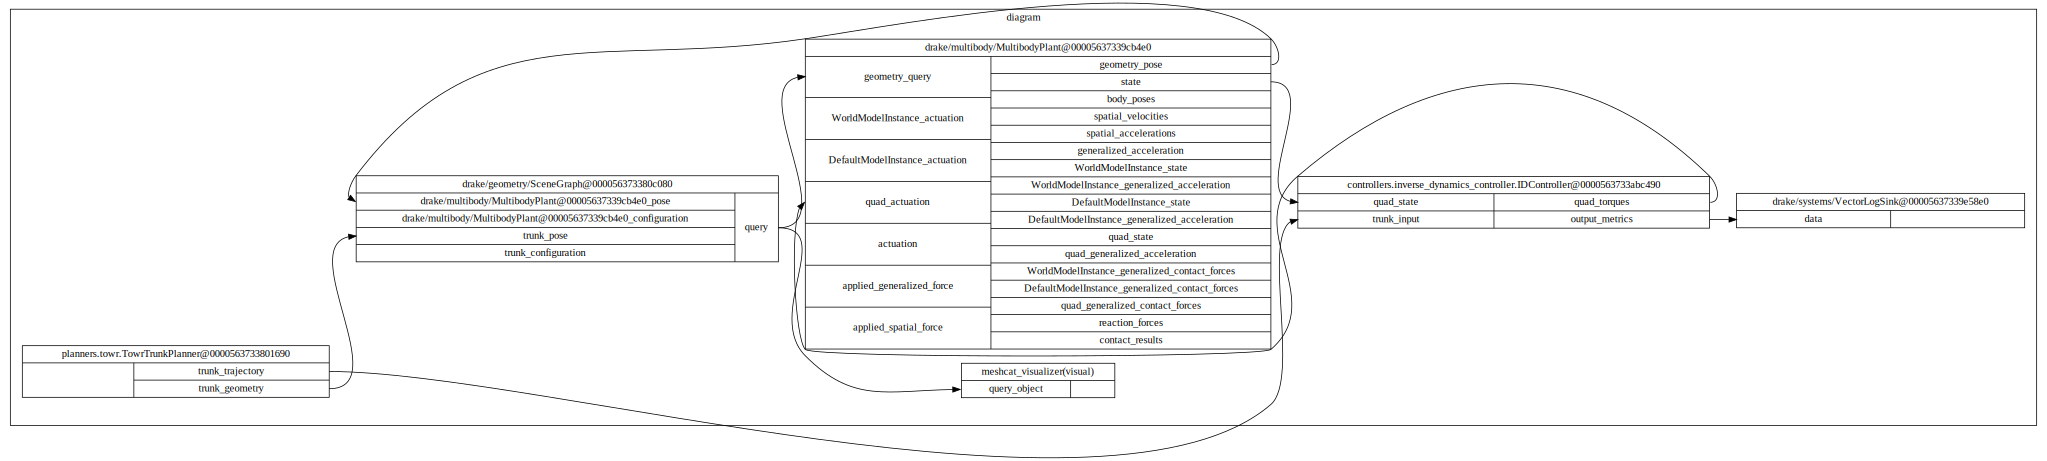

In [13]:
display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

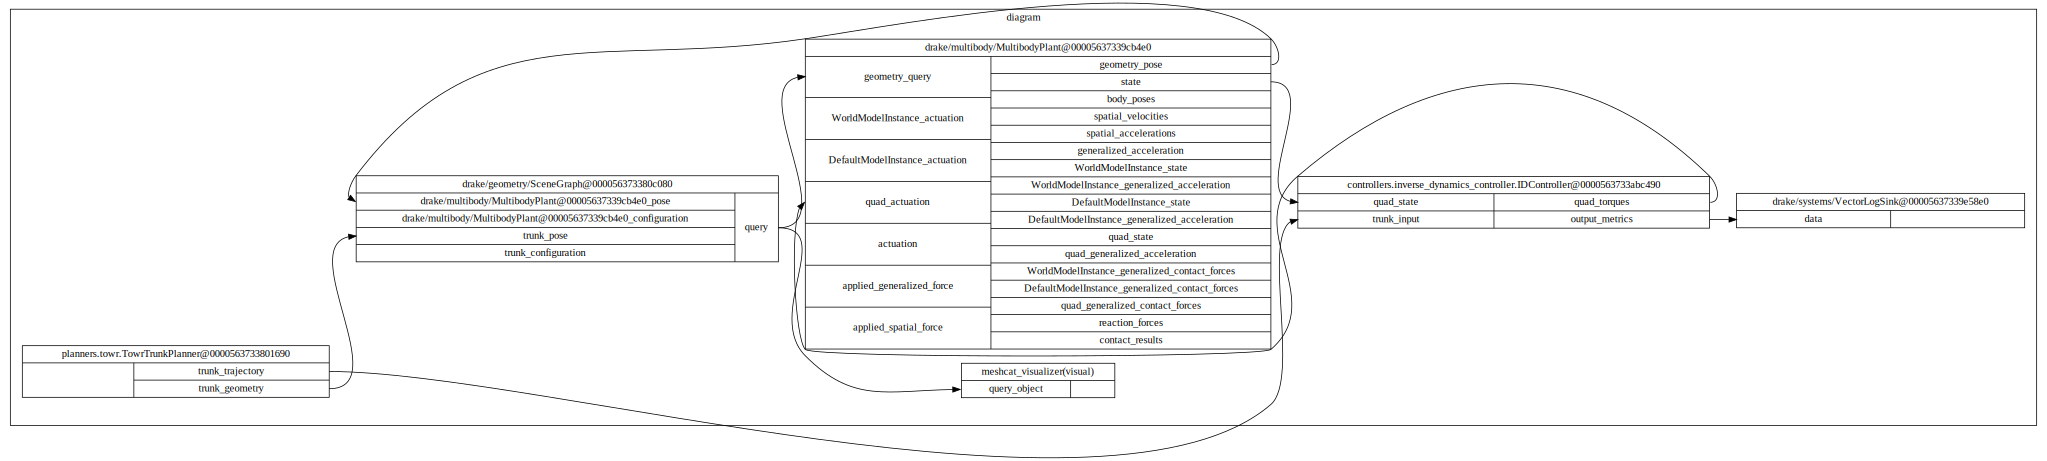

In [14]:
display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(max_depth=1))[0].create_svg()))

In [15]:
# Simulator setup
simulator = Simulator(diagram, diagram_context)
if use_lcm:
    # If we're using LCM to send messages to another simulator or a real
    # robot, we don't want Drake to slow things down, so we'll publish
    # new messages as fast as possible
    simulator.set_target_realtime_rate(0.0)
else:
    simulator.set_target_realtime_rate(target_realtime_rate)

# Set initial states
plant_context = diagram.GetMutableSubsystemContext(plant, diagram_context)
q0 = np.asarray([ 1.0, 0.0, 0.0, 0.0,     # base orientation
                  0.0, 0.0, 0.3,          # base position
                  0.0,-0.8, 1.6, 
                  0.0,-0.8, 1.6, 
                  0.0,-0.8, 1.6, 
                  0.0,-0.8, 1.6])
qd0 = np.zeros(plant.num_velocities())
plant.SetPositions(plant_context,q0)
plant.SetVelocities(plant_context,qd0)

# Run the simulation!
simulator.AdvanceTo(sim_time)

In [16]:
print(plant.num_positions() )  # Number of position variables 
print(plant.num_velocities()) # Number of velocity variables

position_names = plant.GetPositionNames()
velocity_names = plant.GetVelocityNames()

print("position_names")
print(position_names)

print("velocity_names")
print(velocity_names)


19
18
position_names
['quad_$world_body_qw', 'quad_$world_body_qx', 'quad_$world_body_qy', 'quad_$world_body_qz', 'quad_$world_body_x', 'quad_$world_body_y', 'quad_$world_body_z', 'quad_torso_to_abduct_fl_j_q', 'quad_abduct_fl_to_thigh_fl_j_q', 'quad_thigh_fl_to_knee_fl_j_q', 'quad_torso_to_abduct_fr_j_q', 'quad_abduct_fr_to_thigh_fr_j_q', 'quad_thigh_fr_to_knee_fr_j_q', 'quad_torso_to_abduct_hl_j_q', 'quad_abduct_hl_to_thigh_hl_j_q', 'quad_thigh_hl_to_knee_hl_j_q', 'quad_torso_to_abduct_hr_j_q', 'quad_abduct_hr_to_thigh_hr_j_q', 'quad_thigh_hr_to_knee_hr_j_q']
velocity_names
['quad_$world_body_wx', 'quad_$world_body_wy', 'quad_$world_body_wz', 'quad_$world_body_vx', 'quad_$world_body_vy', 'quad_$world_body_vz', 'quad_torso_to_abduct_fl_j_w', 'quad_abduct_fl_to_thigh_fl_j_w', 'quad_thigh_fl_to_knee_fl_j_w', 'quad_torso_to_abduct_fr_j_w', 'quad_abduct_fr_to_thigh_fr_j_w', 'quad_thigh_fr_to_knee_fr_j_w', 'quad_torso_to_abduct_hl_j_w', 'quad_abduct_hl_to_thigh_hl_j_w', 'quad_thigh_hl_to_k